In [ ]:
# Importanto as bibliotecas
import numpy as np 
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sklearn.preprocessing
from sklearn.metrics import r2_score
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential
import visualkeras

In [ ]:
!pip install git+https://github.com/paulgavrikov/visualkeras --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-_nfnya_c
  Running command git clone -q https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-_nfnya_c
     |████████████████████████████████| 992 kB 5.3 MB/s 
  Created wheel for visualkeras: filename=visualkeras-0.0.2-py3-none-any.whl size=13450 sha256=6fbea10cb23d72a53dafba7ddf16faa9c261f6bd9db2a3147ec60b6a78dfd0a2
  Stored in directory: /tmp/pip-ephem-wheel-cache-b4nxop1h/wheels/e6/fe/80/74c54ccb79205ab57079259bc349e1629373e811e1c82ed535
Successfully built visualkeras


In [ ]:
# Install this package to use Colab's GPU for training
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 5 not upgraded.
Need to get 420 MB of archives.
After this operation, 1,622 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.4.1.50-1+cuda11.6 [420 MB]
Fetched 420 MB in 12s (35.5 MB/s)
(Reading database ... 124015 files and directories currently installed.)
Removing libcudnn8-dev (8.1.1.33-1+cuda11.2) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
(Reading database ... 123992 files and directories currently installed.)
Prepari

In [ ]:
# Importando o dataset 
pjme = pd.read_csv('/content/PJME_hourly.csv', index_col=[0], parse_dates=[0])

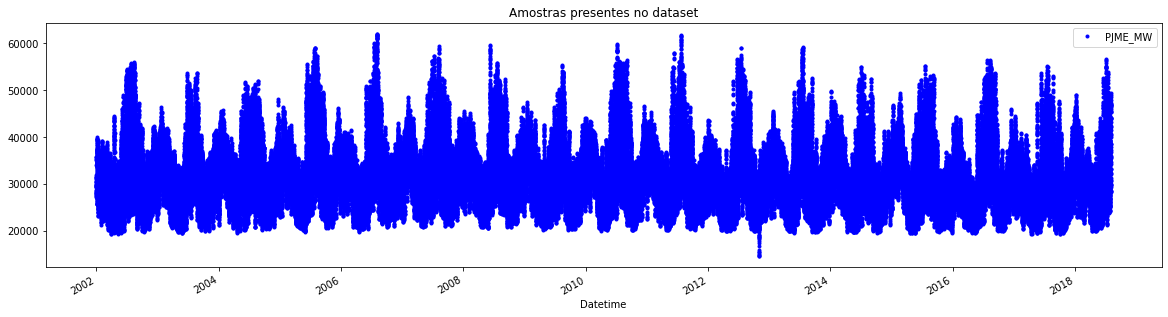

In [ ]:
# Plotando 
_ = pjme.plot(style='.', figsize=(20,5), color='blue', title='Amostras presentes no dataset')

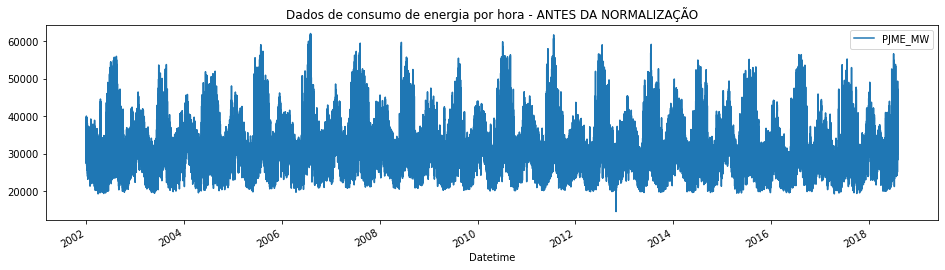

In [ ]:
pjme.plot(figsize=(16,4),legend=True)
plt.title('Dados de consumo de energia por hora - ANTES DA NORMALIZAÇÃO')
plt.show()

In [ ]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    pjme['PJME_MW']=scaler.fit_transform(pjme['PJME_MW'].values.reshape(-1,1))
    return pjme

In [ ]:
pjme_norm = normalize_data(pjme)
pjme.shape

(145366, 1)

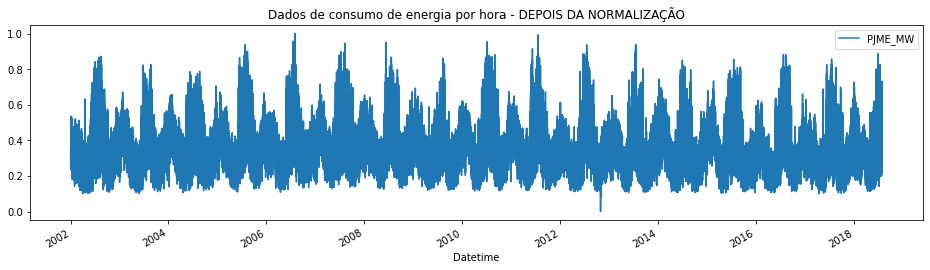

In [ ]:
pjme.plot(figsize=(16,4),legend=True)
plt.title('Dados de consumo de energia por hora - DEPOIS DA NORMALIZAÇÃO')
plt.show()

In [ ]:
split_date = '01-Jan-2014' # 70% do dataset para treinamento e 30% do dataset para teste
train = pjme.loc[pjme.index <= split_date].copy()
test = pjme.loc[pjme.index > split_date].copy()

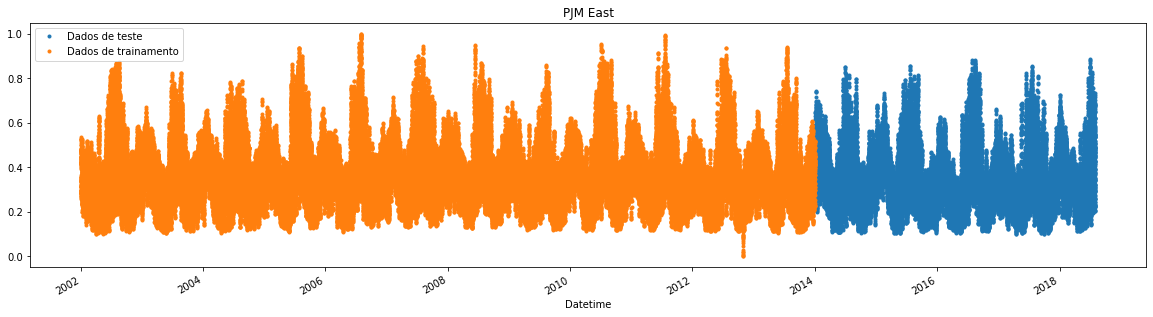

In [ ]:
_ = test \
    .rename(columns={'PJME_MW': 'Dados de teste'}) \
    .join(train.rename(columns={'PJME_MW': 'Dados de trainamento'}), how='outer') \
    .plot(figsize=(20,5), title='PJM East', style='.')

In [ ]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 6189 days are going to be used in test
    X_test = X_train[110000:]             
    y_test = y_train[110000:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:110000]           
    y_train = y_train[:110000]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (110000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test] 

In [ ]:
#create train, test data
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(pjme, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (35346, 20, 1)
y_test.shape =  (35346,)


# RNN

In [ ]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 dropout (Dropout)           (None, 20, 40)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 40)            3240      
                                                                 
 dropout_1 (Dropout)         (None, 20, 40)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 20, 40)            3240      
                                                                 
 dropout_2 (Dropout)         (None, 20, 40)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 20, 40)            3

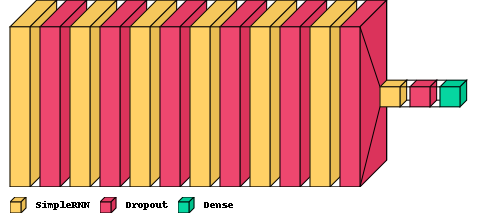

In [ ]:
visualkeras.layered_view(rnn_model, legend=True)

In [ ]:
rnn_model.compile(optimizer="adam",loss="MSE")
history = rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 141s 257ms/step - loss: 4.4096e-04
Epoch 2/10
110/110 [==============================] - 27s 241ms/step - loss: 3.9437e-04
Epoch 3/10
110/110 [==============================] - 26s 240ms/step - loss: 3.8886e-04
Epoch 4/10
110/110 [==============================] - 26s 239ms/step - loss: 3.8542e-04
Epoch 5/10
110/110 [==============================] - 26s 239ms/step - loss: 3.8847e-04
Epoch 6/10
110/110 [==============================] - 26s 239ms/step - loss: 3.8514e-04
Epoch 7/10
110/110 [==============================] - 26s 240ms/step - loss: 3.9439e-04
Epoch 8/10
110/110 [==============================] - 26s 237ms/step - loss: 3.8952e-04
Epoch 9/10
110/110 [==============================] - 26s 239ms/step - loss: 3.9023e-04
Epoch 10/10
110/110 [==============================] - 27s 242ms/step - loss: 3.8673e-04


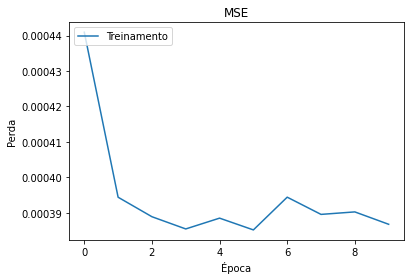

In [ ]:
plt.plot(history.history['loss'])
plt.title('MSE')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend(['Treinamento'], loc='upper left')
plt.show()

In [ ]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

1105/1105 [==============================] - 12s 10ms/step
R2 Score of RNN model =  0.9864758318096755


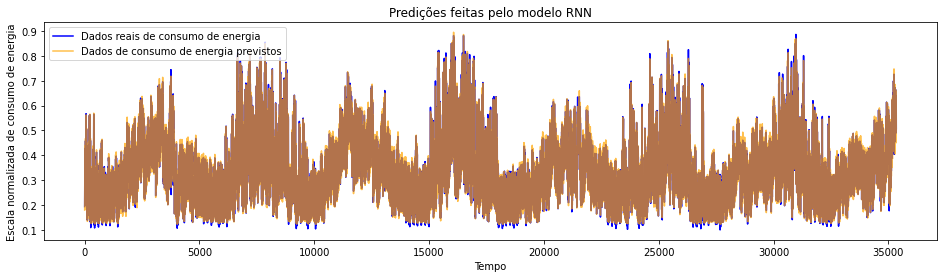

In [ ]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Dados reais de consumo de energia')
    plt.plot(predicted, alpha=0.7, color='orange',label='Dados de consumo de energia previstos')
    plt.title(title)
    plt.xlabel('Tempo')
    plt.ylabel('Escala normalizada de consumo de energia')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predições feitas pelo modelo RNN")

# LSTM

In [ ]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 20, 40)            6720      
                                                                 
 dropout_17 (Dropout)        (None, 20, 40)            0         
                                                                 
 lstm_12 (LSTM)              (None, 20, 40)            12960     
                                                                 
 dropout_18 (Dropout)        (None, 20, 40)            0         
                                                                 
 lstm_13 (LSTM)              (None, 20, 40)            12960     
                                                                 
 dropout_19 (Dropout)        (None, 20, 40)            0         
                                                                 
 lstm_14 (LSTM)              (None, 20, 40)           

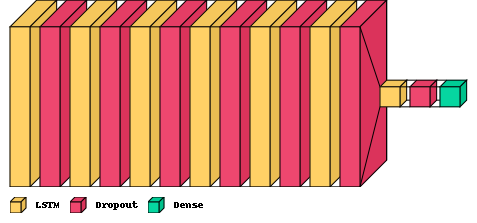

In [ ]:
visualkeras.layered_view(lstm_model, legend=True)

In [ ]:
lstm_model.compile(optimizer="adam",loss="MSE")
history = lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 81s 622ms/step - loss: 0.0249
Epoch 2/10
110/110 [==============================] - 76s 690ms/step - loss: 0.0170
Epoch 3/10
110/110 [==============================] - 76s 695ms/step - loss: 0.0153
Epoch 4/10
110/110 [==============================] - 71s 639ms/step - loss: 0.0141
Epoch 5/10
110/110 [==============================] - 71s 642ms/step - loss: 0.0133
Epoch 6/10
110/110 [==============================] - 66s 603ms/step - loss: 0.0114
Epoch 7/10
110/110 [==============================] - 69s 624ms/step - loss: 0.0089
Epoch 8/10
110/110 [==============================] - 67s 607ms/step - loss: 0.0078
Epoch 9/10
110/110 [==============================] - 68s 622ms/step - loss: 0.0069
Epoch 10/10
110/110 [==============================] - 68s 619ms/step - loss: 0.0053


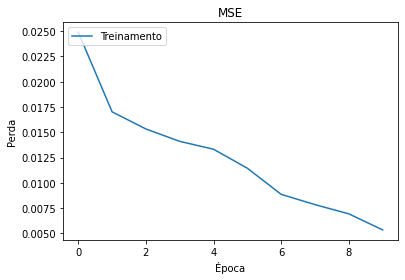

In [ ]:
plt.plot(history.history['loss'])
plt.title('MSE')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend(['Treinamento'], loc='upper left')
plt.show()

In [ ]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

1105/1105 [==============================] - 23s 19ms/step
R^2 Score of LSTM model =  0.854220963844655


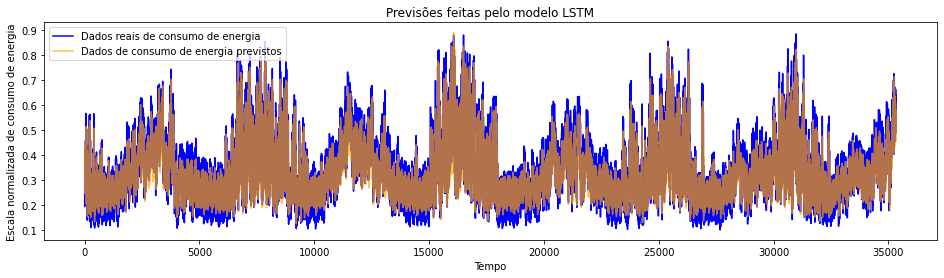

In [ ]:
plot_predictions(y_test, lstm_predictions, "Previsões feitas pelo modelo LSTM")